# Домашняя работа к лекции №6

## 1.Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев.Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
#Напишем функцию, реализующую предсказание в градиентном бустинге.

def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_mse = mean_squared_error(y_train, train_prediction)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {train_mse}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_mse = mean_squared_error(y_test, test_prediction)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {test_mse}')
    return train_mse, test_mse

In [101]:
def get_answers_plot(n_trees, answers):
    fig = plt.figure(figsize=(16,10))
    gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
    axs = gs.subplots(sharey=True)    
    axs[0].set_title('Train')    
    axs[1].set_title('Test')
    for i in answers:
        axs[0].plot(list(range(n_trees-1)), answers[i][1][1:], label=f'depth: {i}')
        axs[1].plot(list(range(n_trees-1)), answers[i][2][1:], label=f'depth: {i}')
    for i in range(len(axs)):
        axs[i].legend(loc='upper right')
    plt.show()

In [70]:
n_trees = 200
depth = [x*2 for x in range(1, 8)]
answers = {}
for i in depth:
    answers[i] = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, coefs, eta)

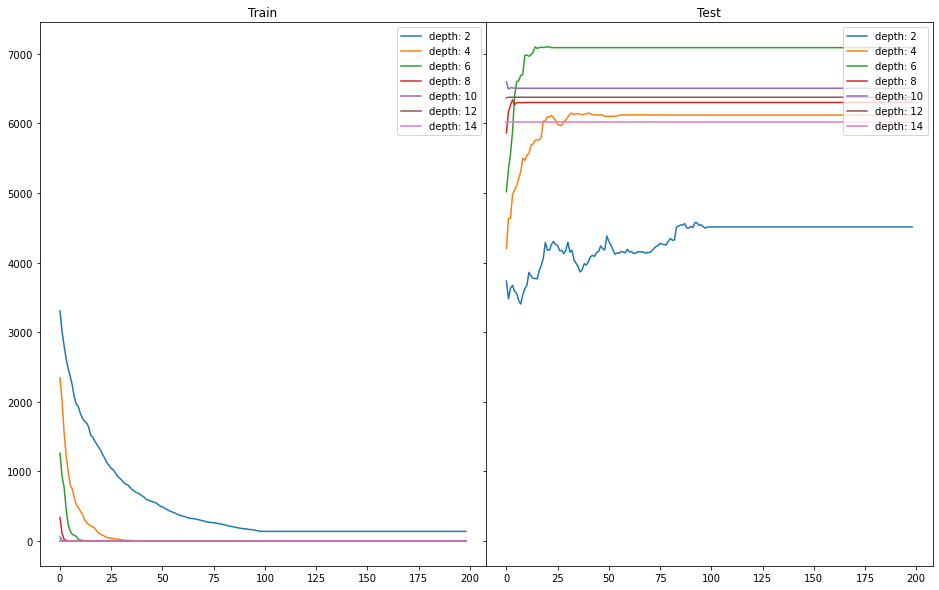

In [102]:
get_answers_plot(n_trees, answers)

### Выводы: на графиках train видно, что с увеличением глубины нужно меньшее количество деревьев для минимизации ошибки. Однако, на тестовом датасете при увеличении глубины явно видно переобучение и с увеличение кол-ва дереьев после определенного порога не влияет на качество модели. Наилучшим вариантом, на основании графика, можно выделить глубину 2 при количестве деревьев до 100. 